In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, vstack

%matplotlib inline

# Custom modules
import const
import func

## Load lookup table & data

In [2]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [3]:
const.TEST_FILES

['test_numeric', 'test_categorical_to_num', 'test_date']

### Load data

In [4]:
num_data = func.load_data_file(const.TRAIN_FILES[0], ftype='bin')
cat_data = func.load_data_file(const.TRAIN_FILES[1], ftype='bin')
num_data_te = func.load_data_file(const.TEST_FILES[0], ftype='bin')
cat_data_te = func.load_data_file(const.TEST_FILES[1], ftype='bin')

y = num_data['data']['y']
ids = np.concatenate([num_data['data']['ids'].Id.values, num_data_te['data']['ids'].Id.values])

num_f_n = num_data['data']['feature_names'][1:]
cat_f_n = cat_data['data']['feature_names'][1:]

num_data = vstack([num_data['data']['features'], num_data_te['data']['features']], format='csr')
cat_data = vstack([cat_data['data']['features'], cat_data_te['data']['features']], format='csr')

Returning <open file '/Volumes/My Book/kaggle_bosch/train_numeric_bin.pkl', mode 'rb' at 0x116365b70>_bin.pkl
Returning <open file '/Volumes/My Book/kaggle_bosch/train_categorical_to_num_bin.pkl', mode 'rb' at 0x116365b70>_bin.pkl
Returning <open file '/Volumes/My Book/kaggle_bosch/test_numeric_bin.pkl', mode 'rb' at 0x116365b70>_bin.pkl
Returning <open file '/Volumes/My Book/kaggle_bosch/test_categorical_to_num_bin.pkl', mode 'rb' at 0x116365b70>_bin.pkl


In [5]:
num_data.shape

(2367495, 968)

In [6]:
del num_data_te, cat_data_te

### Load and adjust lookup table

In [7]:
lut = pd.read_csv(os.path.join(const.DATA_PATH, 'date_feat_lut_V2.csv'))
lut.head()

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num,col_dat,col_num,col_cat,station_V2,line_V2
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0,0.0,0.0,NaN,0.0,1.0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2,1.0,1.0,NaN,0.0,1.0
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4,2.0,2.0,NaN,0.0,1.0
3,0,0,6,7.0,L0_S0_D7,NaN,L0_S0_F6,3.0,3.0,NaN,0.0,1.0
4,0,0,8,9.0,L0_S0_D9,NaN,L0_S0_F8,4.0,4.0,NaN,0.0,1.0


In [8]:
def insert_col_num(x):
    ''' Adds columns number to lookup table'''
    try:
        num_col_n = num_f_n.index(x['name_num'])
        x['col_num'] = num_col_n
    
    except:
        x['col_num'] = np.nan
        
    try:
        cat_col_n = cat_f_n.index(x['name_cat'])
        x['col_cat'] = cat_col_n
    
    except:
        x['col_cat'] = np.nan
        
    return x

In [9]:
lut = lut.apply(lambda x: insert_col_num(x), axis=1)

In [10]:
# Create lookup table for the numeric matrix so we can easily go from feature nr to column no
lut_num_indices = lut.groupby(['line','station_V2']).col_num.agg(['min','max'])
lut_num_indices.head()

min   max
line station_V2            
0    0.0          0.0  11.0
     1.0         12.0  13.0
     2.0         14.0  22.0
     3.0         23.0  31.0
     4.0         32.0  33.0

In [11]:
# Create lookup table for the numeric matrix so we can easily go from feature nr to column no

lut_cat_indices = lut.groupby(['line','station_V2']).col_cat.agg(['min','max'])
lut_cat_indices.head()

min   max
line station_V2            
0    0.0          NaN   NaN
     1.0          0.0   3.0
     2.0          4.0  21.0
     3.0         22.0  39.0
     4.0         40.0  45.0

In [12]:
print lut_num_indices.shape
print lut_cat_indices.shape

(128, 2)
(128, 2)


In [13]:
n_stations = lut.station_V2.nunique()
n_features = lut.feature_nr.nunique()
n_samples = num_data.shape[0]
print('Number of stations: {}'.format(n_stations))
print('Number of features: {}'.format(n_features))
print('Number of samples: {}'.format(n_samples))

Number of stations: 128
Number of features: 3139
Number of samples: 2367495


## Create paths per station
We assume that when a sample has a measurement value for one of the features of the station, it has passed this station. We also assume that samples always pass the stations in order.

To calculate this matrix we need to sum over all the features per station. Most efficient way to do this is by matrix multiplication:
A         B                        C
[0 1 1]   [1 0] = [1 1] -> '>0' -> [1 1]
[0 0 1] x [1 0]   [0 1]            [0 1]
[1 1 0]   [0 1]   [2 1]            [1 1]

We have to do this for the numeric and categorical features and concate them later.

In [14]:
# Create matrix B for numeric features
station_filter_num = np.zeros((lut_num_indices.shape[0], num_data.shape[1]))
for i in range(lut_num_indices.shape[0]):
    if lut_num_indices.iloc[i]['min']>=0:
        i_s = int(lut_num_indices.iloc[i]['min'])
        i_e = int(lut_num_indices.iloc[i]['max']+1)
        #print i_s, i_e
        station_filter_num[i, i_s:i_e] = 1
station_filter_num = csr_matrix(station_filter_num)

In [15]:
# Create matrix C for numeric features
num_per_station = (num_data * station_filter_num.T)>0

In [16]:
# Create matrix B for categorical features

station_filter_cat = np.zeros((lut_cat_indices.shape[0], cat_data.shape[1]))
for i in range(lut_cat_indices.shape[0]):
    if lut_cat_indices.iloc[i]['min']>=0:
        i_s = int(lut_cat_indices.iloc[i]['min'])
        i_e = int(lut_cat_indices.iloc[i]['max']+1)
        #print i_s, i_e
        station_filter_cat[i, i_s:i_e] = 1
station_filter_cat = csr_matrix(station_filter_cat)

In [17]:
# Create matrix C for categorical features
cat_per_station = (cat_data * station_filter_cat.T)>0

In [18]:
# Double check dimensions
print num_per_station.shape
print cat_per_station.shape

(2367495, 128)
(2367495, 128)


In [19]:
# Now get a array of station nr visited for each
a=time.time()
stations_passed = []
for i in range(num_data.shape[0]):
    if not i % 100000:
        print('Calculated stations for {} of {}'.format(i+1, num_data.shape[0]))
    
    stations_passed.append(np.unique(np.concatenate([num_per_station[i,:].nonzero()[1], cat_per_station[i,:].nonzero()[1]], axis=0)))
    
    # Below is ~10% slower
    #stations_passed.append(np.asarray(set(num_data[i,:].nonzero()[1]) & set(cat_data[i,:].nonzero()[1])))
print time.time()-a

Calculated stations for 1 of 2367495
Calculated stations for 100001 of 2367495
Calculated stations for 200001 of 2367495
Calculated stations for 300001 of 2367495
Calculated stations for 400001 of 2367495
Calculated stations for 500001 of 2367495
Calculated stations for 600001 of 2367495
Calculated stations for 700001 of 2367495
Calculated stations for 800001 of 2367495
Calculated stations for 900001 of 2367495
Calculated stations for 1000001 of 2367495
Calculated stations for 1100001 of 2367495
Calculated stations for 1200001 of 2367495
Calculated stations for 1300001 of 2367495
Calculated stations for 1400001 of 2367495
Calculated stations for 1500001 of 2367495
Calculated stations for 1600001 of 2367495
Calculated stations for 1700001 of 2367495
Calculated stations for 1800001 of 2367495
Calculated stations for 1900001 of 2367495
Calculated stations for 2000001 of 2367495
Calculated stations for 2100001 of 2367495
Calculated stations for 2200001 of 2367495
Calculated stations for 23

In [20]:
# Method used to convert list of stations visited to either a string '01111000' or array [0,1,0,1,0,0] or both
def to_path_info_per_item(items_visited, n_items, o_type='string'):
    tmp = np.zeros((n_items)).astype(int)
    
    for n in items_visited: tmp[n]=1
    
    if o_type=='string':
        return ''.join(map(str,tmp))
    elif o_type=='array':
        return tmp
    elif o_type=='both':
        return ''.join(map(str,tmp)), tmp

In [21]:
# Convert list of stations to binary vectors
ps_strings = []
ps_arr = []
for i in range(n_samples):
    if not i % 100000:
        print('Converted {} of {}'.format(i+1, n_samples))
    s_s, s_arr = to_path_info_per_item(stations_passed[i], n_stations, o_type='both')
    ps_strings.append(s_s)
    ps_arr.append(s_arr)

Converted 1 of 2367495
Converted 100001 of 2367495
Converted 200001 of 2367495
Converted 300001 of 2367495
Converted 400001 of 2367495
Converted 500001 of 2367495
Converted 600001 of 2367495
Converted 700001 of 2367495
Converted 800001 of 2367495
Converted 900001 of 2367495
Converted 1000001 of 2367495
Converted 1100001 of 2367495
Converted 1200001 of 2367495
Converted 1300001 of 2367495
Converted 1400001 of 2367495
Converted 1500001 of 2367495
Converted 1600001 of 2367495
Converted 1700001 of 2367495
Converted 1800001 of 2367495
Converted 1900001 of 2367495
Converted 2000001 of 2367495
Converted 2100001 of 2367495
Converted 2200001 of 2367495
Converted 2300001 of 2367495


In [22]:
# Now finally get the unique values based on the strings
u_str, u_ix, i_ix = np.unique(ps_strings, return_index=True, return_inverse=True)
u_arr = np.array([ps_arr[n] for n in u_ix])

In [23]:
print('Number of unique paths: {}'.format(u_arr.shape[0]))

Number of unique paths: 15210


In [24]:
# Store the sample_id with unique path id
pd.DataFrame({'id': ids, 'u_arr_ix': i_ix}).to_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_sample_paths_station.csv'), 
                                                   index=False)
# Store the unique strings with id
pd.DataFrame({'id': range(u_arr.shape[0]), 'u_str': u_str}).to_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_unique_paths_station.csv'), 
                                                   index=False)

In [529]:
def distance_matrix(bin_arr_list, verbose=False):

    tmp = np.empty((bin_arr_list.shape[0], bin_arr_list.shape[0]))
    tmp[:] = np.nan
    
    for i in range(bin_arr_list.shape[0]):
        if (not i % 1000) & verbose:
            print('{}/{}'.format(i+1,bin_arr_list.shape[0]))
            
        for j in range(bin_arr_list.shape[0]):
            #if j>i:
                ##a = np.array([int(n) for n in list(unique_string[i])])
                #b = np.array([int(n) for n in list(unique_string[j])])
            tmp[i,j] = np.count_nonzero( bin_arr_list[i]!=bin_arr_list[j] )
    return tmp

In [530]:
tmp = distance_matrix(u_arr, True)

1/7927
1001/7927
2001/7927
3001/7927
4001/7927
5001/7927
6001/7927
7001/7927


In [545]:
from sklearn.cluster import KMeans

n_cluster=7
km = KMeans(n_clusters=n_cluster)
tmp

%time km.fit(u_arr)

clusters = km.labels_.tolist()

CPU times: user 845 ms, sys: 36.9 ms, total: 882 ms
Wall time: 329 ms


In [546]:
len(clusters)

7927

In [547]:
from sklearn import decomposition

In [548]:
ns=7600
ne=ns+20
print clusters[ns:ne]
[np.count_nonzero( u_arr[i]!=u_arr[i+1]) for i in range(ns, ne)]

[0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 6, 6, 6, 6]


[4, 3, 5, 4, 23, 17, 2, 4, 6, 17, 16, 2, 7, 23, 4, 14, 2, 3, 1, 3]

In [491]:
u_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ..., 
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [498]:
u_arr[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1])

In [549]:
for n_clus in range(n_cluster):
    u_clus = np.array([u_arr[i] for i,n in enumerate(clusters) if n==n_clus])
    tmp2 = distance_matrix(u_clus)
    print('Mean of matrix: {}'.format(np.nanmean(tmp2)))
    print('Max of matrix: {}'.format(np.nanmax(tmp2)))

Mean of matrix: 10.1913603494
Max of matrix: 22.0
Mean of matrix: 7.69794206171
Max of matrix: 18.0
Mean of matrix: 9.00874023438
Max of matrix: 24.0
Mean of matrix: 5.83962469506
Max of matrix: 16.0
Mean of matrix: 8.1257786224
Max of matrix: 24.0
Mean of matrix: 8.45945743111
Max of matrix: 19.0
Mean of matrix: 7.69768243477
Max of matrix: 18.0


In [523]:
n_clus=3

In [543]:
nn_clus = np.array([n for i,n in enumerate(clusters) if n==n_clus])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

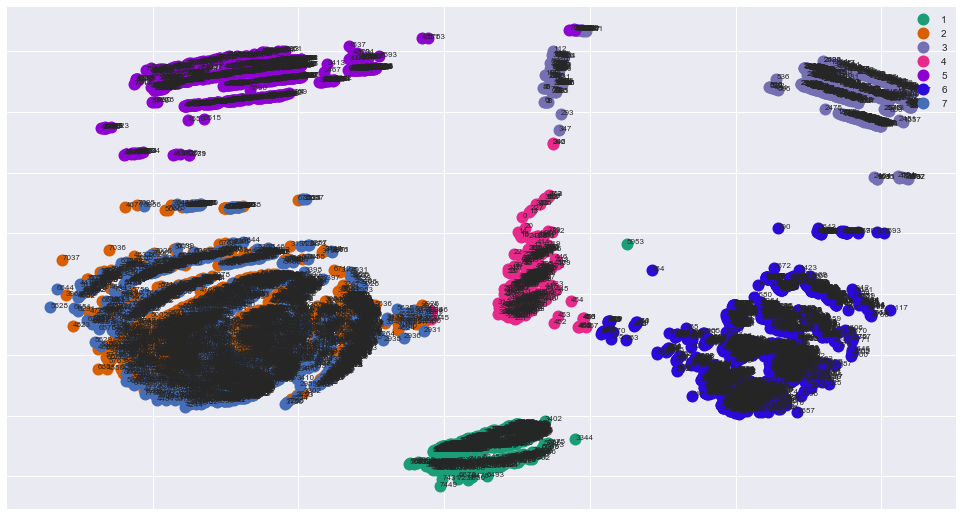

In [552]:
titles = [str(i) for i in range(tmp.shape[0])]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a',4: '#8d03d1', 5:'#2b09db', 6:'#466eb8'}

#set up cluster names using a dict
cluster_names = {0: '1', 
                 1: '2', 
                 2: '3', 
                 3: '4', 
                 4: '5', 
                 5: '6', 
                 6: '7'}

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot


In [253]:
pd.DataFrame({'string':station_strings}).to_csv(os.path.join(const.DATA_PATH,'path_string_per_station.csv'), index_label='Id')

In [224]:
stations = []
for i in range(num_per_station.shape[0]):
    if not i % 100000:
        print('Hashed {} of {}'.format(i+1, num_per_station.shape[0]))
    stations.append((np.unique(np.concatenate([num_per_station[i,:].nonzero()[1], cat_per_station[i,:].nonzero()[1]], axis=0))))

Hashed 1 of 1183747
Hashed 100001 of 1183747
Hashed 200001 of 1183747
Hashed 300001 of 1183747
Hashed 400001 of 1183747
Hashed 500001 of 1183747
Hashed 600001 of 1183747
Hashed 700001 of 1183747
Hashed 800001 of 1183747
Hashed 900001 of 1183747
Hashed 1000001 of 1183747
Hashed 1100001 of 1183747


In [555]:
pd.DataFrame({'string':ustring}).to_csv(os.path.join(const.DATA_PATH,'path_unique_string_per_station.csv'), index_label='Id')

In [223]:
hashes = []
for i in range(num_per_station.shape[0]):
    if not i % 10000:
        print('Hashed {} of {}'.format(i+1, num_per_station.shape[0]))
    hashes.append(hash(str(np.concatenate([num_per_station[i,:].nonzero()[1], cat_per_station[i,:].nonzero()[1]], axis=0))))

Hashed 1 of 1183747
Hashed 10001 of 1183747
Hashed 20001 of 1183747
Hashed 30001 of 1183747


KeyboardInterrupt: 

In [562]:
lut.feature_nr.max()

4262

In [209]:
pd.Series(hashes).nunique()

11889

In [216]:
pd.Series(hashes).value_counts().head()

 2962780449862125699    42784
 3996857553603850002    41720
 1219758100697939015    17464
-4164725308699375738    16736
-4145515165199554915    15595
dtype: int64

In [210]:
hash_vals = pd.Series(hashes).value_counts()

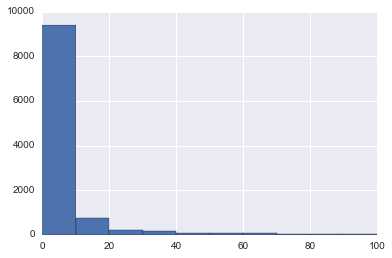

In [213]:
hash_vals.hist(range=[0,100])

In [215]:
(hash_vals<10).sum()

9395

## Create hashes based on non-zero values of num and cat data per station


## Create hashes based on non-zero values of num and cat data per feature
This results in 24775 different hashes. Most common hashes are:

- -7807953387334174150:    8602
- 4448795901197187659:    8570
- -4556810841609180581:    8374
- 6868875294474782730:    8272
- 4906655664106956524:    6679
 
 of those, 12157 have a single sample
 
 of those, 20205 have less than 10 samples

In [34]:
def to_path_info_per_feature(features_visited, n_features, o_type='string'):
    tmp = np.zeros((n_features)).astype(int)
    
    for n in features_visited: tmp[n]=1
    
    if o_type=='string':
        return ''.join(map(str,tmp))
    elif o_type=='array':
        return tmp
    elif o_type=='both':
        return ''.join(map(str,tmp)), tmp

In [ ]:
# Generate a list of all the features products have values for
features_visited = []
for i in range(n_samples):
    if not i % 100000:
        print('Calculated {} of {}'.format(i+1, n_samples))
    #stations_visited.append(hash(str(np.concatenate([num_data[i,:].nonzero()[1], cat_data[i,:].nonzero()[1]], axis=0).data)))
    features_visited.append(np.unique(np.concatenate([num_data[i,:].nonzero()[1], cat_data[i,:].nonzero()[1]], axis=0)))

Calculated 1 of 2367495
Calculated 100001 of 2367495
Calculated 200001 of 2367495
Calculated 300001 of 2367495


In [ ]:
# Covert to list of stations to binary vectors
station_strings = []
station_arr = []
for i in range(n_samples):
    if not i % 100000:
        print('Hashed {} of {}'.format(i+1, n_samples))
    s_s, s_arr = to_path_info_per_feature(features_visited[i], n_features, o_type='both')
    station_strings.append(s_s)
    station_arr.append(s_arr)

In [ ]:
# Now finally get the unique values based on the strings
u_str, u_ix, i_ix = np.unique(station_strings, return_index=True, return_inverse=True)
u_arr = np.array([station_arr[n] for n in u_ix])

In [ ]:
print('Number of unique paths: {}'.format(u_arr.shape[0]))

In [ ]:
# Store the sample_id with unique path id
pd.DataFrame({'id': ids, 'u_arr_ix': i_ix}).to_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_sample_paths_per_feature.csv'), 
                                                   index=False)
# Store the unique strings with id
pd.DataFrame({'id': range(u_arr.shape[0]), 'u_str': u_str}).to_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_unique_paths_per_feature.csv'), 
                                                   index=False)